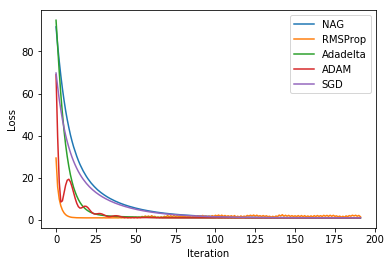

In [8]:
from sklearn import datasets as ds
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os


feature_size = 123
bias = np.zeros(shape=[feature_size + 1, 1])
bias[len(bias)-1][0] = 1.
C = 1

def loss(x, y, w):
    pre = np.matmul(x, w)
    hinge_loss = np.maximum(1 - y * pre, 0)
    loss = np.mean(hinge_loss ** 2) + C * np.sum((w - bias) ** 2)
    return loss


def compute_gradient(x, y, w):
    pre = np.matmul(x, w)
    hinge_loss = np.maximum(1 - y * pre, 0)
    hinge_loss_gradient = -np.matmul(x.transpose(), hinge_loss * y) / len(y)
    gradient = hinge_loss_gradient + 2 * C * (w - bias)
    return gradient


global_list = {'NAG_momentum': 0, 'RMS_expectation': 1, 'ADAM_m': 0, 'ADAM_G': 0,
               'ADADELDA_G': 0, 'ADADELDA_t': 0}

def optimizer(method, x, y, w):
    global global_list
    if method == 'SGD':
        lr = 0.01
        w -= lr * compute_gradient(x, y, w)
    if method == 'NAG':
        lr = 0.01
        gamma = 0.9
        momentum = global_list['NAG_momentum']
        gradient = compute_gradient(x, y, w - momentum * lr * gamma)
        momentum = momentum * lr + gradient
        w -= lr * momentum
        global_list['NAG_momentum'] = momentum
    if method == 'RMSProp':
        lr = 0.1
        expectation = global_list['RMS_expectation']
        gamma = 0.95
        delta = 10e-7
        gradient = compute_gradient(x, y, w)
        expectation = gamma * expectation + (1 - gamma) * (gradient ** 2)
        global_list['RMS_expectation'] = expectation
        w -= lr * gradient / (np.sqrt(expectation) + delta)
    if method == 'ADAM':
        delta = 10e-8
        beta = 0.9
        gamma = 0.999
        lr = 0.01
        m = global_list['ADAM_m']
        G = global_list['ADAM_G']
        gradient = compute_gradient(x, y, w)
        m = beta * m + (1 - beta) * gradient
        G = gamma * G + (1 - gamma) * (gradient ** 2)
        m1 = m / (1 - beta)
        G1 = G / (1 - beta)
        w -= (lr * m1) / (np.sqrt(G1) + delta)
        global_list['ADAM_m'] = m
        global_list['ADAM_G'] = G
    if method == 'Adadelta':
        # adadelta_para_list = {'delta':10e-7, 'miu':0.9, 'learning_rate':0.1}
        G = global_list['ADADELDA_G']
        t = global_list['ADADELDA_t']
        gamma = 0.9
        delta = 10e-7
        lr = 0.1
        grad = compute_gradient(x, y, w)
        G = gamma * G + (1 - gamma) * (grad ** 2)
        w -= (lr * grad * np.sqrt(t + delta)) / (np.sqrt(G + delta))
        t = gamma * t + (1 - gamma) * (w ** 2)
        #
        global_list['ADADELDA_G'] = G
        global_list['ADADELDA_t'] = t


if __name__ == '__main__':
    x_train, y_train = ds.load_svmlight_file("C:\\Users\\baosonglin\\Desktop\\lab2-1.txt")
    x_test, y_test = ds.load_svmlight_file("C:\\Users\\baosonglin\\Desktop\\a9a.t")

    num_samples, num_features = x_train.shape
    num_test_samples, num_test_features = x_test.shape

    x_train = x_train.toarray()
    temp = np.ones(shape=[num_samples, 1], dtype=np.float32)
    x_train = np.concatenate([x_train, temp], axis=1)

    x_test = x_test.toarray()
    temp = np.zeros(shape=[num_test_samples, 1], dtype=np.float32)
    temp1 = np.ones(shape=[num_test_samples, 1], dtype=np.float32)
    x_test = np.concatenate([x_test, temp, temp1], axis=1)

    y_train = y_train.reshape([len(y_train), 1])
    y_test = y_test.reshape([len(y_test), 1])


    def shuffle_data():
        global x_train, y_train
        p = np.random.get_state()
        np.random.shuffle(x_train)
        np.random.set_state(p)
        np.random.shuffle(y_train)

    batch_size = 512
    data_size = num_samples
    #检查剩下的够不够一个batch
    def check_data(batch_count):
        if (1 + batch_count) * batch_size <= data_size:
            check_dict = {'x': x_train[batch_count * batch_size : (batch_count + 1) * batch_size],
                         'y': y_train[batch_count * batch_size : (batch_count + 1) * batch_size]}
        else:
            check_dict = {'x': x_train[batch_count * batch_size : data_size],
                         'y': y_train[batch_count * batch_size : data_size]}
        return check_dict

    methods = ['NAG', 'RMSProp', 'Adadelta', 'ADAM','SGD']

    for method in methods:
        iters = []
        test_errors = []
        w = np.random.rand(feature_size+1, 1)
        count = 0
        for i in range(0, 3):
            shuffle_data()
            for batch_count in range(0, int(data_size / batch_size) + 1):
                check_dict = check_data(batch_count)
                iters.append(count)
                count += 1
                optimizer(method=method, x=check_dict['x'], y=check_dict['y'], w=w)
                test_errors.append(loss(x_test, y_test, w))
        plt.plot(iters, test_errors, label=method)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()